In [1]:
import sys
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from Networks.AIRNet import AIRNet
from Networks.InceptionNet import InceptionNet
from Networks.DenseNet import DenseNet

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

sys.dont_write_bytecode = True

In [2]:
data_dir = r"/home/ychen921/808E/final_project/Dataset/Overfit"
saved_fig_dir = r"/home/ychen921/808E/final_project/Figures/DenseNet/"

data_transform = transforms.Compose([
        transforms.Resize((128, 128)),  # Resize images to 256x256
        transforms.ToTensor()            # Convert images to tensors
    ])

In [3]:
def show_image_pair(mov, fix, wrap, reg, i):
    # Create a figure with 2 rows and 2 columns for subplots
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    # Plot moving image (grayscale)
    axes[0, 0].imshow(mov, cmap='gray')
    axes[0, 0].set_title('Moving')
    axes[0, 0].axis('off')

    # Plot fixed image (grayscale)
    axes[0, 1].imshow(fix, cmap='gray')
    axes[0, 1].set_title('Fixed')
    axes[0, 1].axis('off')

    # Plot wrapped image (grayscale)
    axes[1, 0].imshow(wrap, cmap='gray')
    axes[1, 0].set_title('Wrapped')
    axes[1, 0].axis('off')

    # Plot registration image (RGB or grayscale)
    if len(reg.shape) == 2:
        # Grayscale image
        axes[1, 1].imshow(reg, cmap='gray')
        axes[1, 1].set_title('Registration ')
    else:
        # RGB image
        axes[1, 1].imshow(reg)
        axes[1, 1].set_title('Registration')
    axes[1, 1].axis('off')
    save_name = saved_fig_dir+'demo_'+str(i)+'.png'
    plt.savefig(save_name, bbox_inches='tight')

/home/ychen921/anaconda3/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


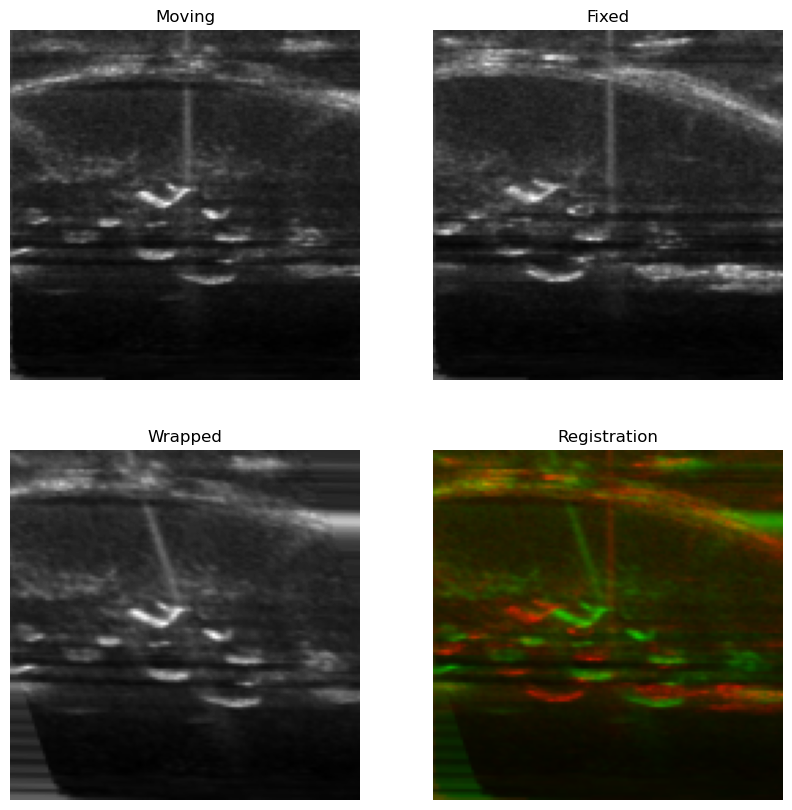

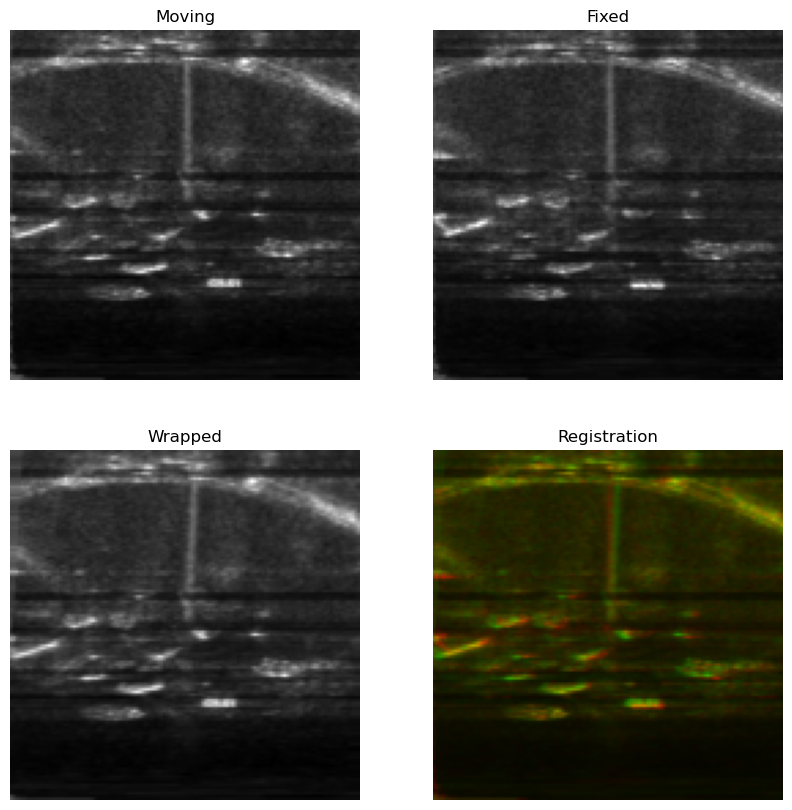

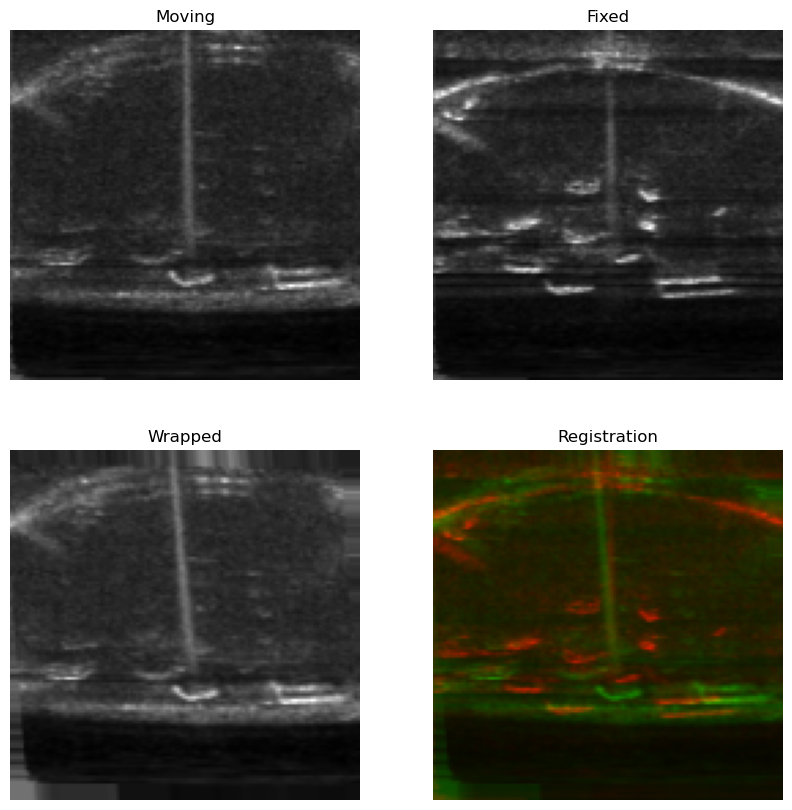

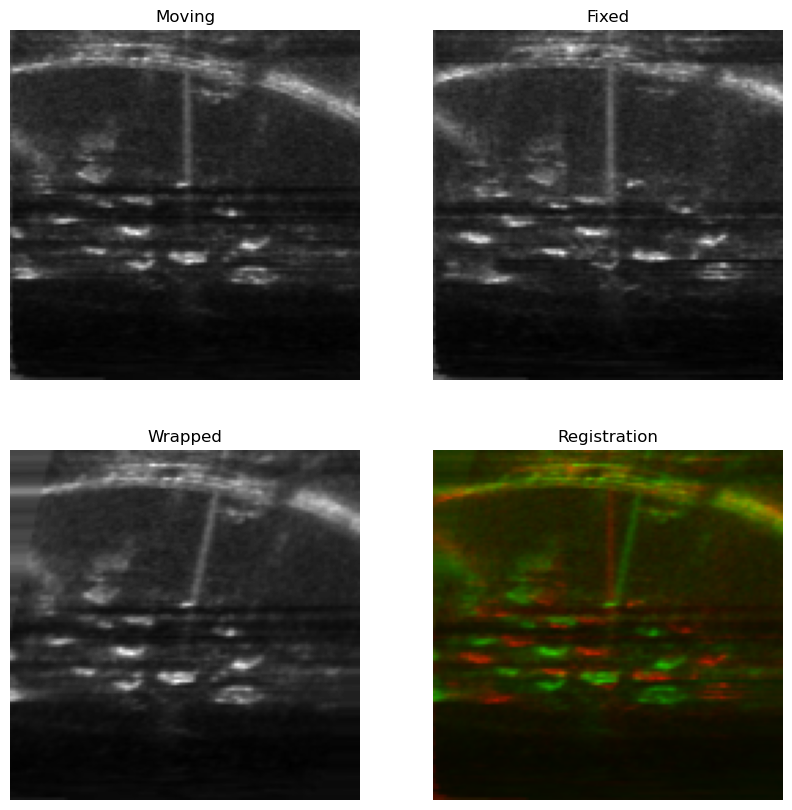

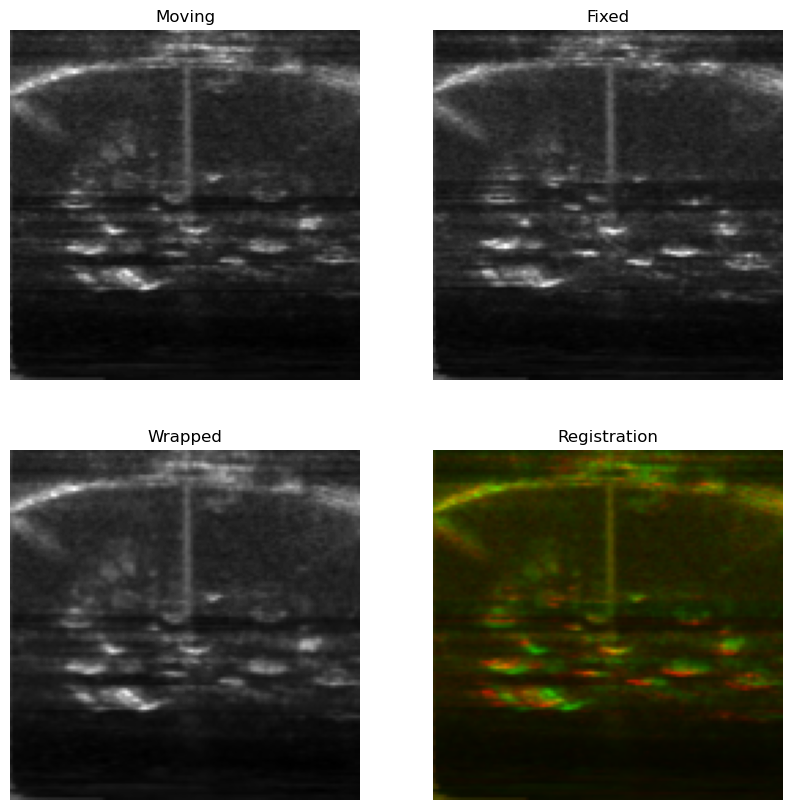

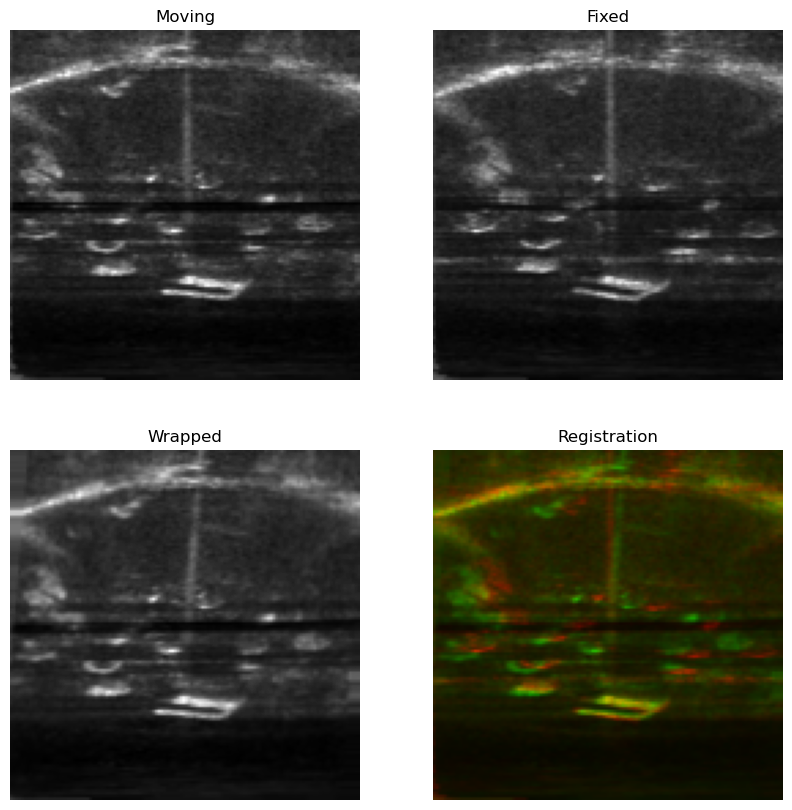

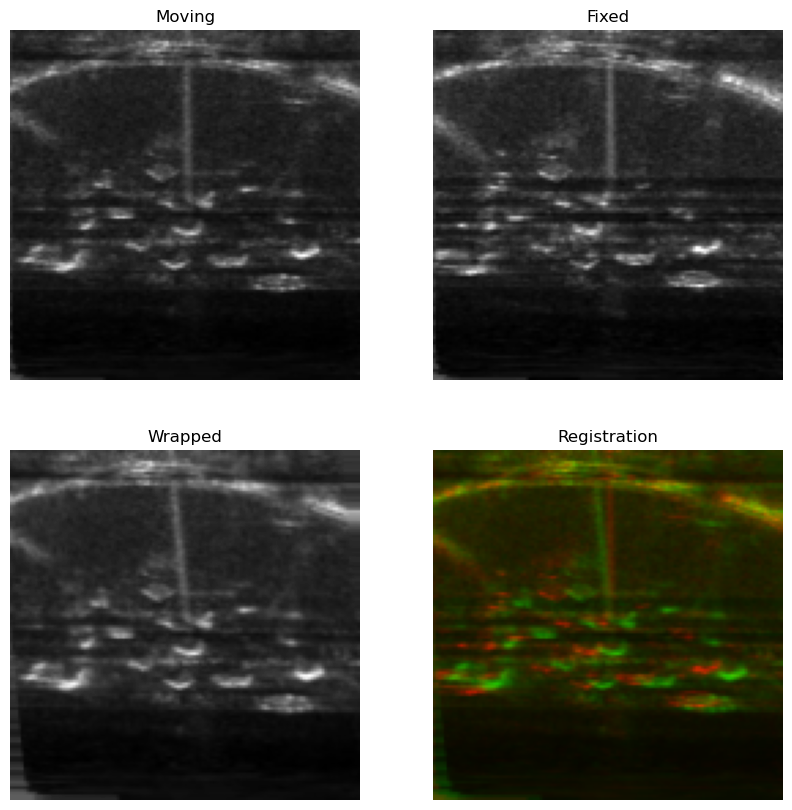

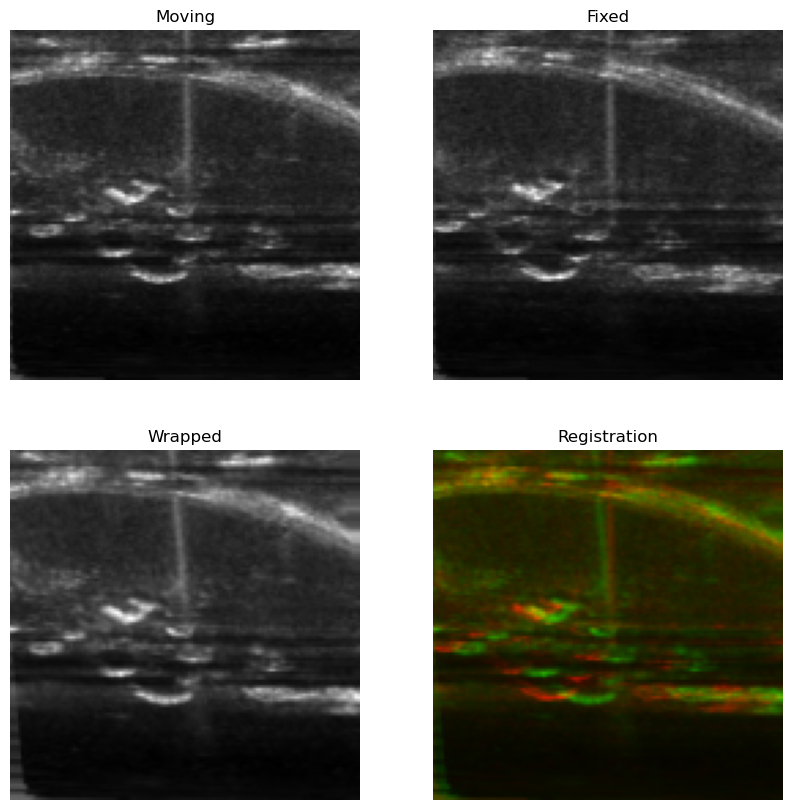

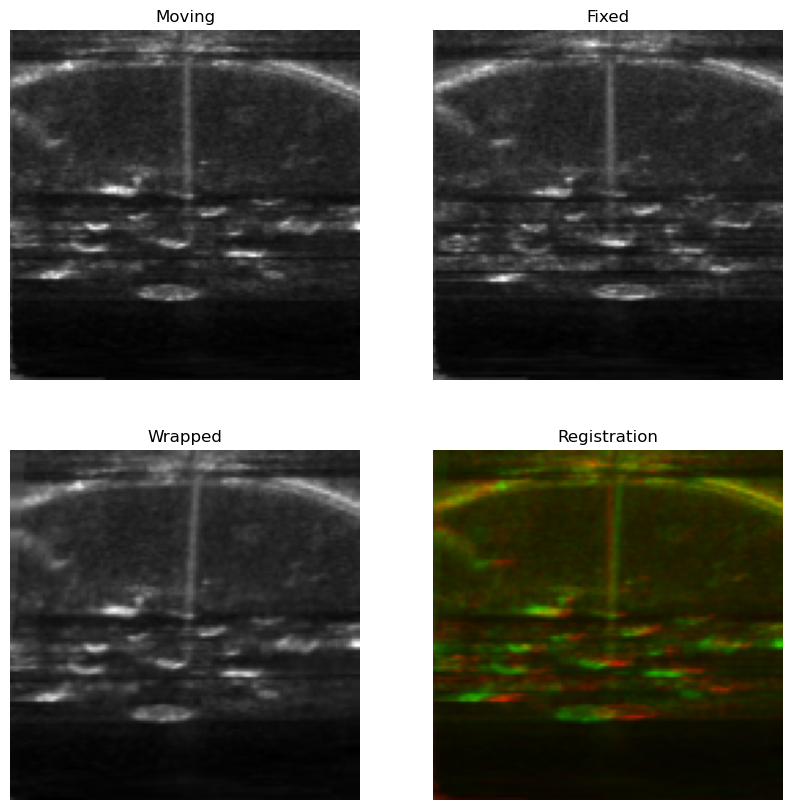

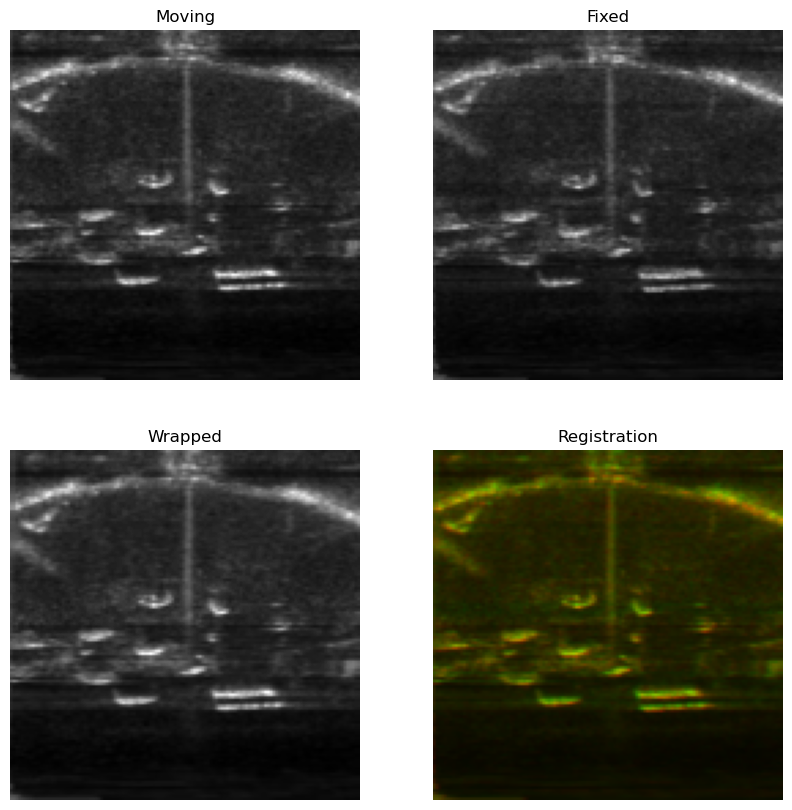

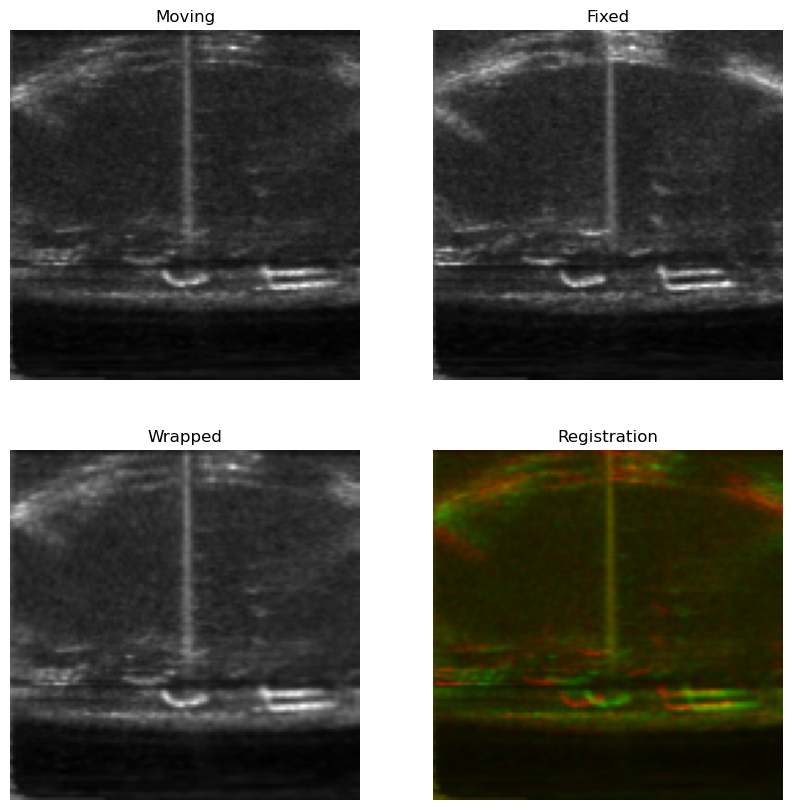

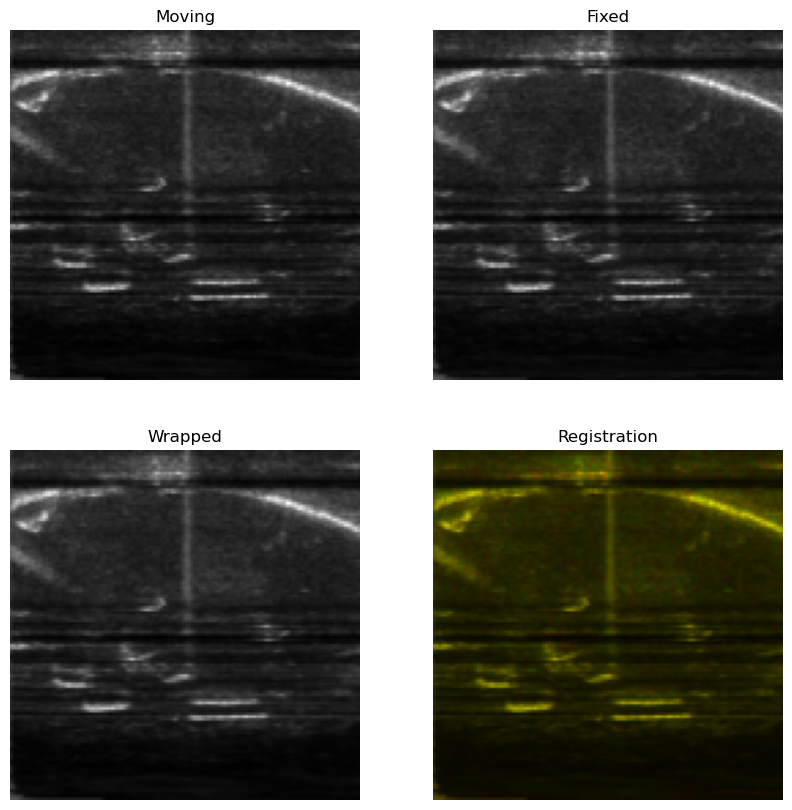

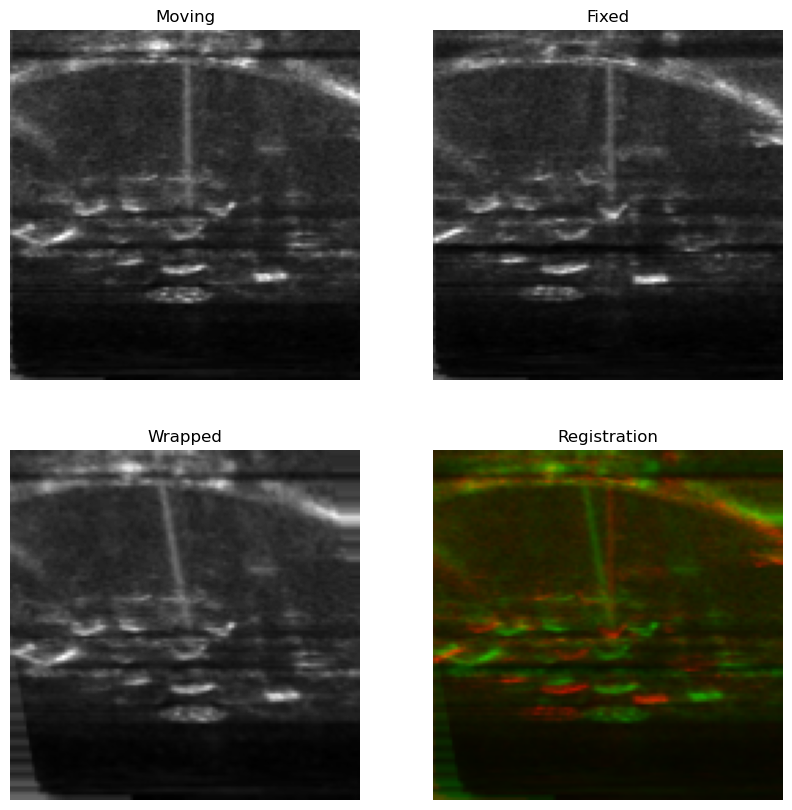

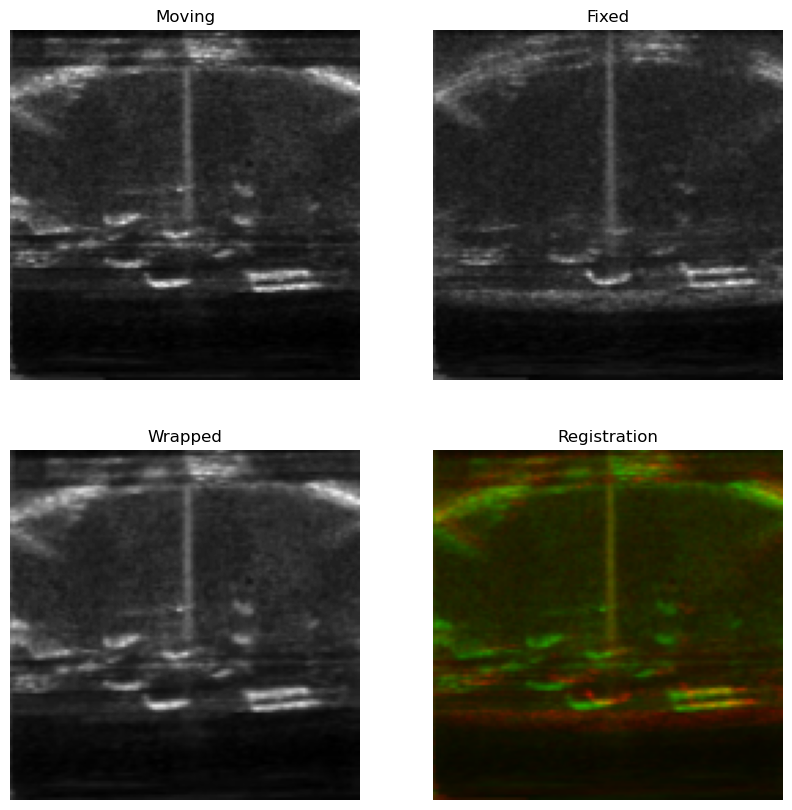

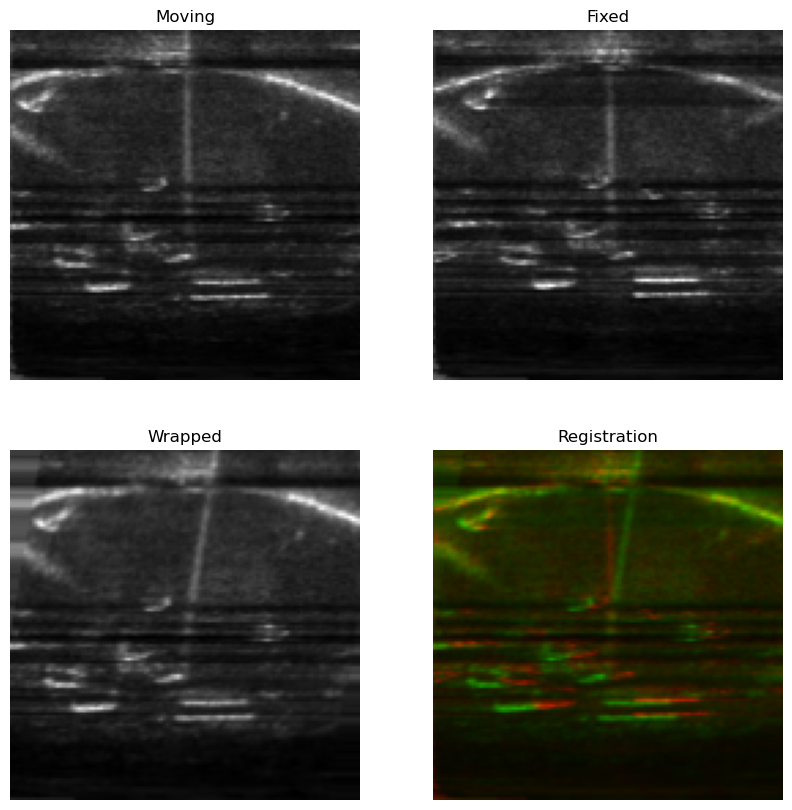

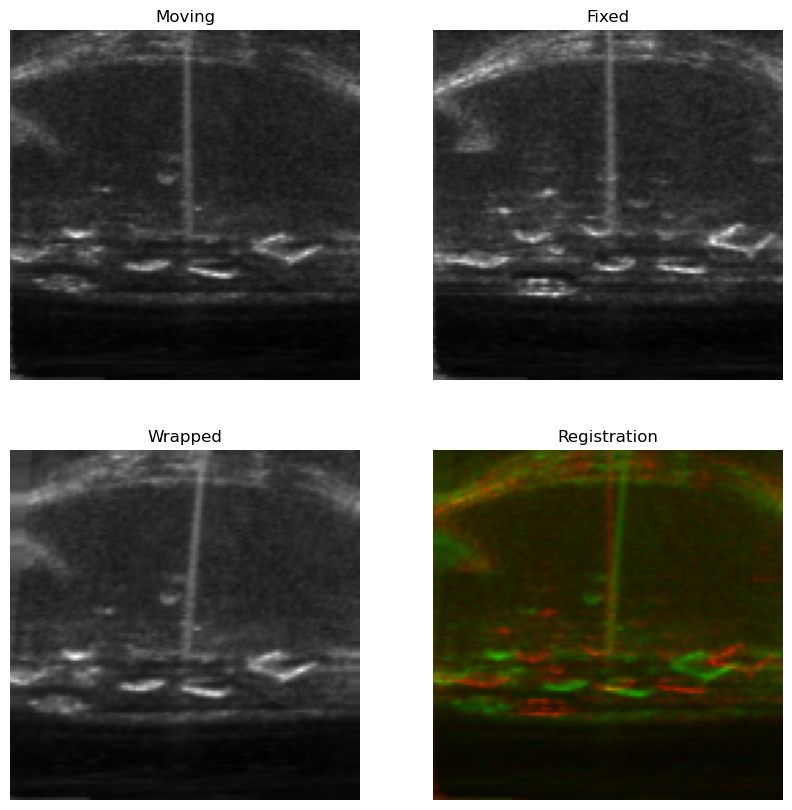

In [5]:
from DataReader.DataReader import SonarPairDataset

image_pair_dataset = SonarPairDataset(data_folder=data_dir, transform=data_transform)
batch_size = 16
data_loader = DataLoader(image_pair_dataset, batch_size=batch_size, shuffle=True)

model = DenseNet().to(device)
# model = InceptionNet().to(device)
# model = AIRNet().to(device)

saved_model = '/home/ychen921/808E/final_project/Dense_ckpts' + '/' + str(74) + '_model.pt'

# Load checkpoint
checkpoint = torch.load(saved_model)
model.load_state_dict(checkpoint['model_state_dict'])

with torch.no_grad():
    for batch in data_loader:
        fix_img, mov_img = batch
        fix_img = (fix_img/255.0).to(device)
        mov_img = (mov_img/255.0).to(device)
        wraped_img, _ = model(fix_img, mov_img)

        for i in range(batch_size):
            moving = mov_img[i].permute(1, 2, 0).cpu().detach().numpy().reshape(128,128)
            fixed = fix_img[i].permute(1, 2, 0).cpu().detach().numpy().reshape(128,128)
            wraped = wraped_img[i].permute(1, 2, 0).cpu().detach().numpy().reshape(128,128)

            height, width = fixed.shape
            registration = np.zeros((height, width, 3))
            registration[:, :, 0] = fixed*255**2
            registration[:, :, 1] = wraped*255**2
            show_image_pair(moving, fixed, wraped, np.clip(registration, 0, 255).astype(np.uint8), i)
        break